# <center>  CNN
<center>Zander Bonnet
<center>October 23, 2024



Dataset: COVID-19 Xray Dataset (Train & Test Sets) from Kaggle

This dataset is a collection of X-Ray images of COVID-19 patient's chests. The images are classified as either pneumonia or normal. We the CNN model to detect the differences in the pictured lungs classify them as being lungs that have pneumonia or not.



In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khoongweihao/covid19-xray-dataset-train-test-sets")

print("Path to dataset files:", path)

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/zanderbonnet/.cache/kagglehub/datasets/khoongweihao/covid19-xray-dataset-train-test-sets/versions/1


In [3]:
train_path = path + '/xray_dataset_covid19/train'

folds = os.listdir(train_path)

filepaths = []
labels = []

for fold in folds:
    foldpath = os.path.join(train_path, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

files = pd.Series(filepaths, name= 'filepaths')
labels = pd.Series(labels, name='labels')

train = pd.concat([files, labels], axis= 1)
train

,filepaths,labels
0,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
1,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
2,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
3,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
4,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
...,...,...
143,/Users/zanderbonnet/.cache/kagglehub/datasets/...,NORMAL
144,/Users/zanderbonnet/.cache/kagglehub/datasets/...,NORMAL
145,/Users/zanderbonnet/.cache/kagglehub/datasets/...,NORMAL
146,/Users/zanderbonnet/.cache/kagglehub/datasets/...,NORMAL


In [4]:
# Read in files
test_path = path + '/xray_dataset_covid19/test'

folds = os.listdir(test_path)

filepaths = []
labels = []

for fold in folds:
    foldpath = os.path.join(test_path, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

files = pd.Series(filepaths, name= 'filepaths')
labels = pd.Series(labels, name='labels')

testFull = pd.concat([files, labels], axis= 1)
testFull.head()

,filepaths,labels
0,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
1,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
2,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
3,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA
4,/Users/zanderbonnet/.cache/kagglehub/datasets/...,PNEUMONIA


In [5]:
#create validation and test sets
valid, test = train_test_split(testFull,  train_size = 0.4, random_state = 99, shuffle = True)

In [6]:
#Transform images into an acceptable format for CNN

B_SIZE = 10
img_size = (224,224)

train_IG = ImageDataGenerator()
test_IG = ImageDataGenerator()

train_gen = train_IG.flow_from_dataframe(train, x_col = 'filepaths', y_col = 'labels', target_size= img_size,
                                        class_mode='categorical', color_mode='rgb',shuffle=True,
                                        batch_size=B_SIZE)

validation_gen = test_IG.flow_from_dataframe(valid, x_col = 'filepaths', y_col = 'labels', target_size= img_size,
                                        class_mode='categorical', color_mode='rgb',shuffle=True,
                                        batch_size=B_SIZE)

test_gen = test_IG.flow_from_dataframe(test, x_col = 'filepaths', y_col = 'labels', target_size= img_size,
                                        class_mode='categorical', color_mode='rgb',shuffle=True,
                                        batch_size=B_SIZE)

Found 148 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.


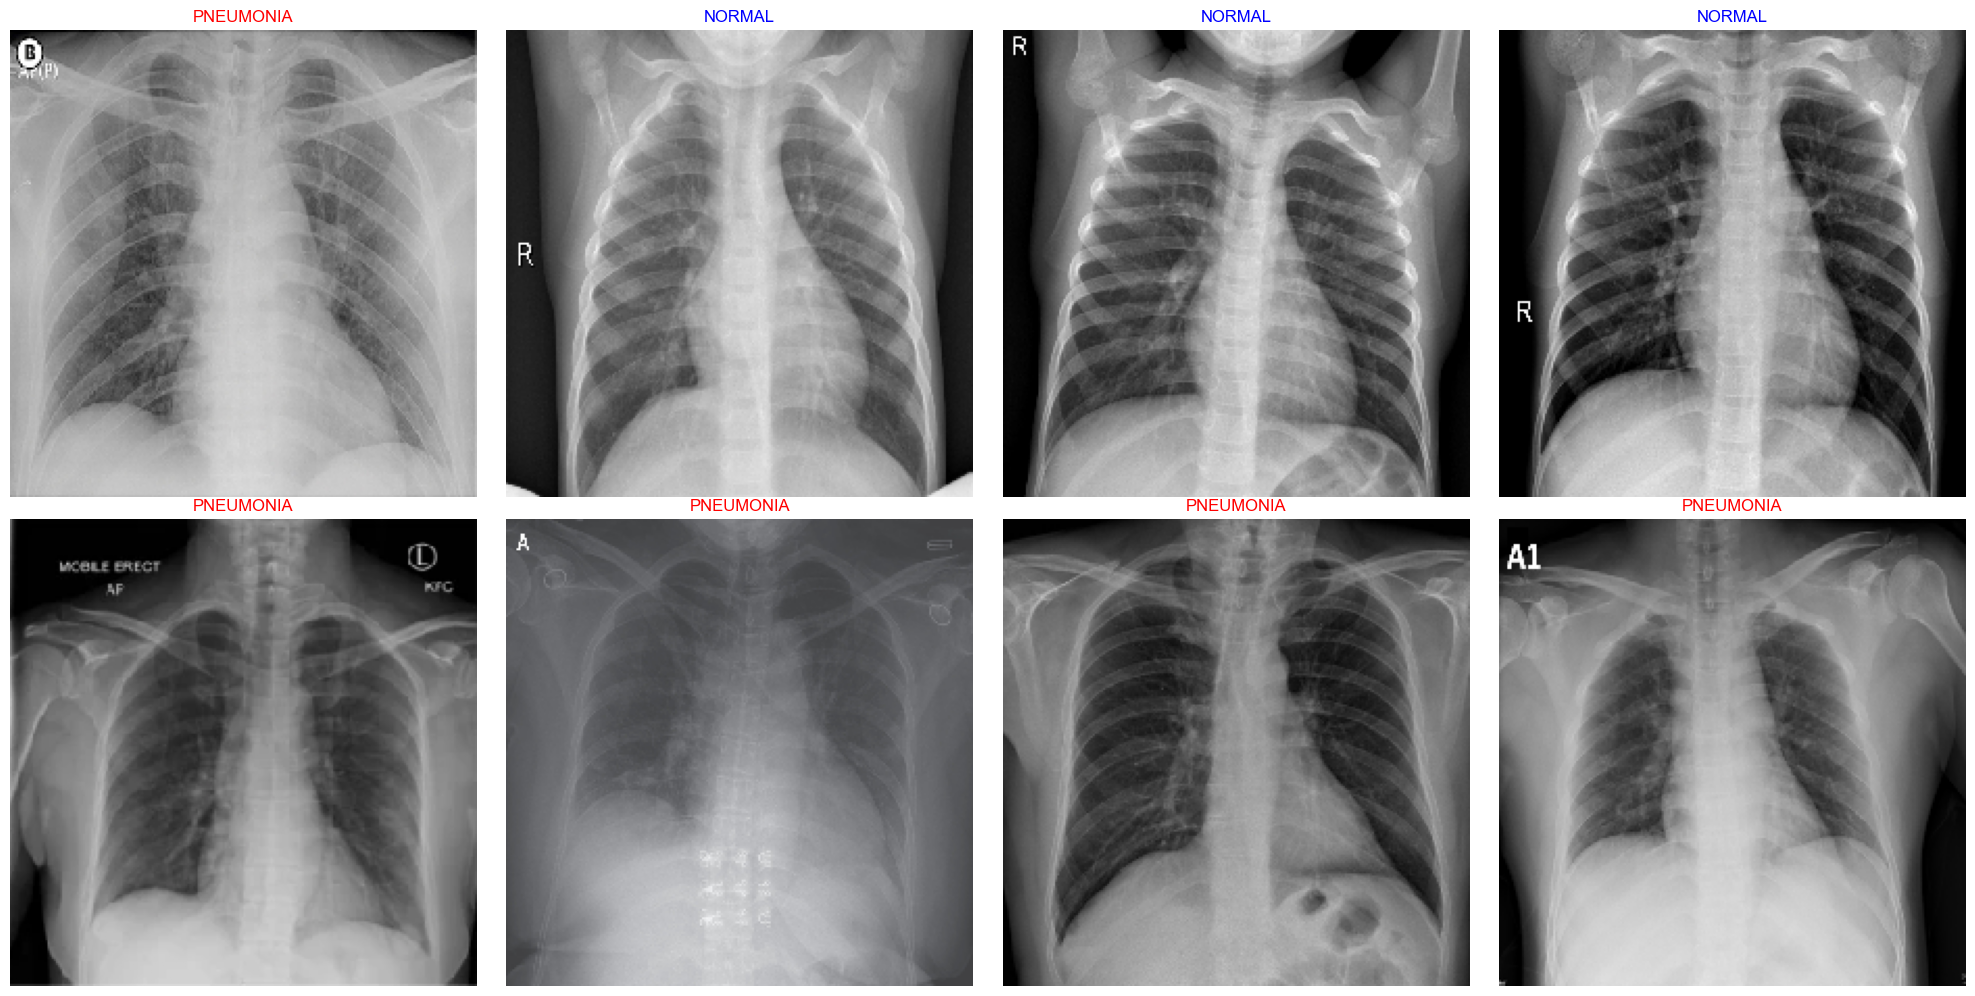

In [7]:
#Visuallize x-ray images

g_dict = train_gen.class_indices 
classes = list(g_dict.keys()) 
images, labels = next(train_gen) 

plt.figure(figsize= (20, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    if class_name == 'NORMAL':
        plt.title(class_name, color = 'blue')
    else:
        plt.title(class_name, color = 'red')
    plt.axis('off')    
plt.tight_layout()
plt.show()

In [8]:
#define model

model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  
])

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


I chose to use maximum pooling. This was the best option because we wanted to extract small intricacies in the image. If I had decided on average pooling, the model might underrepresent the slice, as it may only contain small parts of the pneumonia signals. This would cause the value to be smaller then we want to pass on. The downside of this is that the model is very sensitive to disturbances in the images.

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,457,122 (9.37 MB)

 Trainable params: 2,457,122 (9.37 MB)

 Non-trainable params: 0 (0.00 B)

# Adam

In [10]:
opt = optimizers.Adam()
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [11]:
hist = model.fit(train_gen, 
                epochs = 85,
                validation_data = validation_gen,
                callbacks=[early_stopping])

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.4543 - loss: 37.1119 - val_accuracy: 0.4375 - val_loss: 0.5802
Epoch 2/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8672 - loss: 0.3225 - val_accuracy: 1.0000 - val_loss: 0.0562
Epoch 3/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9538 - loss: 0.1699 - val_accuracy: 1.0000 - val_loss: 0.0676
Epoch 4/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9684 - loss: 0.1204 - val_accuracy: 1.0000 - val_loss: 0.0537
Epoch 5/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9397 - loss: 0.1509 - val_accuracy: 0.9375 - val_loss: 0.1119
Epoch 6/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9775 - loss: 0.0507 - val_accuracy: 0.9375 - val_loss: 0.0590
Epoch 7/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9850 - loss: 0.0330 - val_accuracy: 1.0000 - val_loss: 0.0122
Epoch 8/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9831 - loss: 0.0288 - val_accuracy: 1.0000

In [12]:
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(validation_gen)
test_score = model.evaluate(test_gen)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9077 - loss: 0.3642
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0085
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9417 - loss: 0.0659


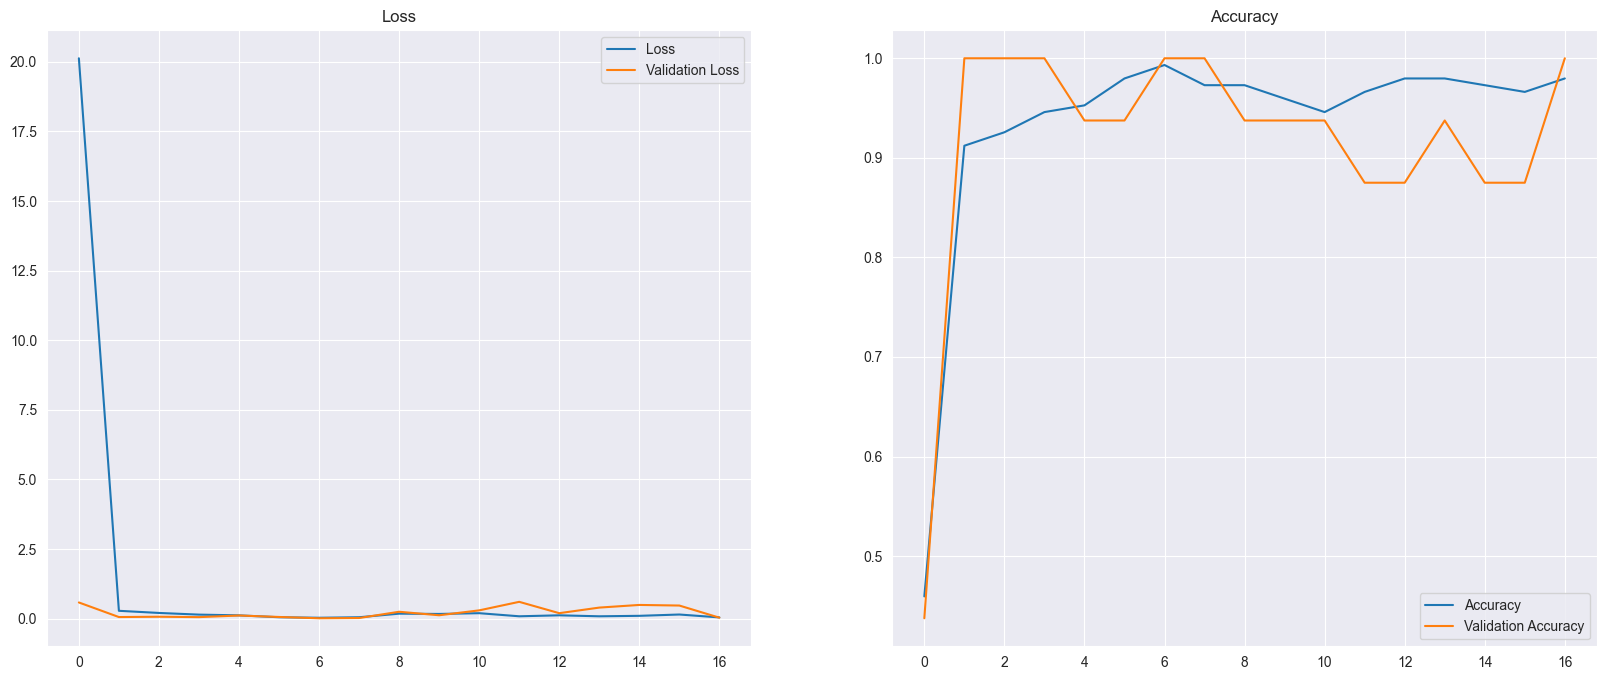

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set(title = 'Loss')
ax[0].plot(hist.history['loss'], label = 'Loss')
ax[0].plot(hist.history['val_loss'], label = 'Validation Loss')
ax[0].legend()

ax[1].set(title = 'Accuracy')
ax[1].plot(hist.history['accuracy'], label = 'Accuracy')
ax[1].plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
ax[1].legend()
plt.show()

# Nadam

In [14]:
model2 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  
])

In [15]:
opt2 = optimizers.Nadam()
model2.compile(optimizer = opt2, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [16]:
hist2 = model2.fit(train_gen, 
                epochs = 85,
                validation_data = validation_gen,
                callbacks=[early_stopping])

Epoch 1/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5547 - loss: 45.3020 - val_accuracy: 0.9375 - val_loss: 0.2557
Epoch 2/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8480 - loss: 0.3863 - val_accuracy: 0.8750 - val_loss: 0.3283
Epoch 3/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9307 - loss: 0.2354 - val_accuracy: 1.0000 - val_loss: 0.0549
Epoch 4/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8393 - loss: 0.6239 - val_accuracy: 1.0000 - val_loss: 0.0737
Epoch 5/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9413 - loss: 0.1879 - val_accuracy: 0.9375 - val_loss: 0.1156
Epoch 6/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9182 - loss: 0.3438 - val_accuracy: 1.0000 - val_loss: 0.1064
Epoch 7/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9384 - loss: 0.1882 - val_accuracy: 1.0000 - val_loss: 0.0561
Epoch 8/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9417 - loss: 0.1695 - val_accuracy: 1.00

In [17]:
train_score2 = model2.evaluate(train_gen)
valid_score2 = model2.evaluate(validation_gen)
test_score2 = model2.evaluate(test_gen)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8891 - loss: 1.5075
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 7.1465e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8833 - loss: 2.9685


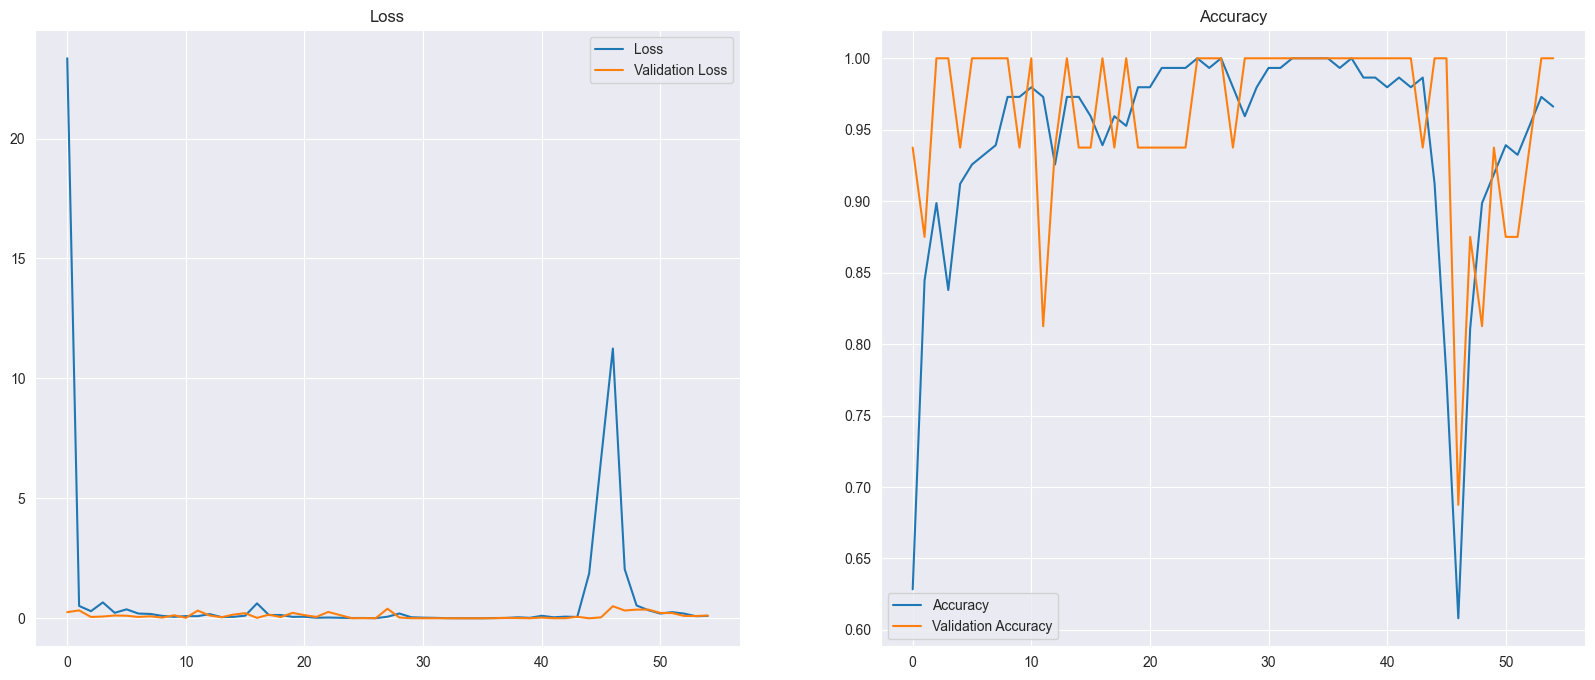

In [18]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set(title = 'Loss')
ax[0].plot(hist2.history['loss'], label = 'Loss')
ax[0].plot(hist2.history['val_loss'], label = 'Validation Loss')
ax[0].legend()

ax[1].set(title = 'Accuracy')
ax[1].plot(hist2.history['accuracy'], label = 'Accuracy')
ax[1].plot(hist2.history['val_accuracy'], label = 'Validation Accuracy')
ax[1].legend()
plt.show()

# SGD

In [19]:
model3 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  
])

In [20]:
opt3 = optimizers.SGD(clipvalue=1)
model3.compile(optimizer = opt3, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [21]:
hist3 = model3.fit(train_gen, 
                epochs = 85,
                validation_data = validation_gen,
                callbacks=[early_stopping])


Epoch 1/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3906 - loss: 981.7434 - val_accuracy: 0.6250 - val_loss: 0.6891
Epoch 2/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4793 - loss: 0.7082 - val_accuracy: 0.6250 - val_loss: 0.6693
Epoch 3/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7222 - loss: 0.6691 - val_accuracy: 0.8125 - val_loss: 0.6260
Epoch 4/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.6899 - loss: 0.6411 - val_accuracy: 0.9375 - val_loss: 0.5024
Epoch 5/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7216 - loss: 0.7982 - val_accuracy: 0.9375 - val_loss: 0.4806
Epoch 6/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7927 - loss: 0.5227 - val_accuracy: 1.0000 - val_loss: 0.2756
Epoch 7/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7512 - loss: 0.5586 - val_accuracy: 1.0000 - val_loss: 0.2723
Epoch 8/85
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.8533 - loss: 0.4384 - val_accuracy: 1.000

In [22]:
train_score3 = model3.evaluate(train_gen)
valid_score3 = model3.evaluate(validation_gen)
test_score3 = model3.evaluate(test_gen)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 9.5589e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0056
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0334


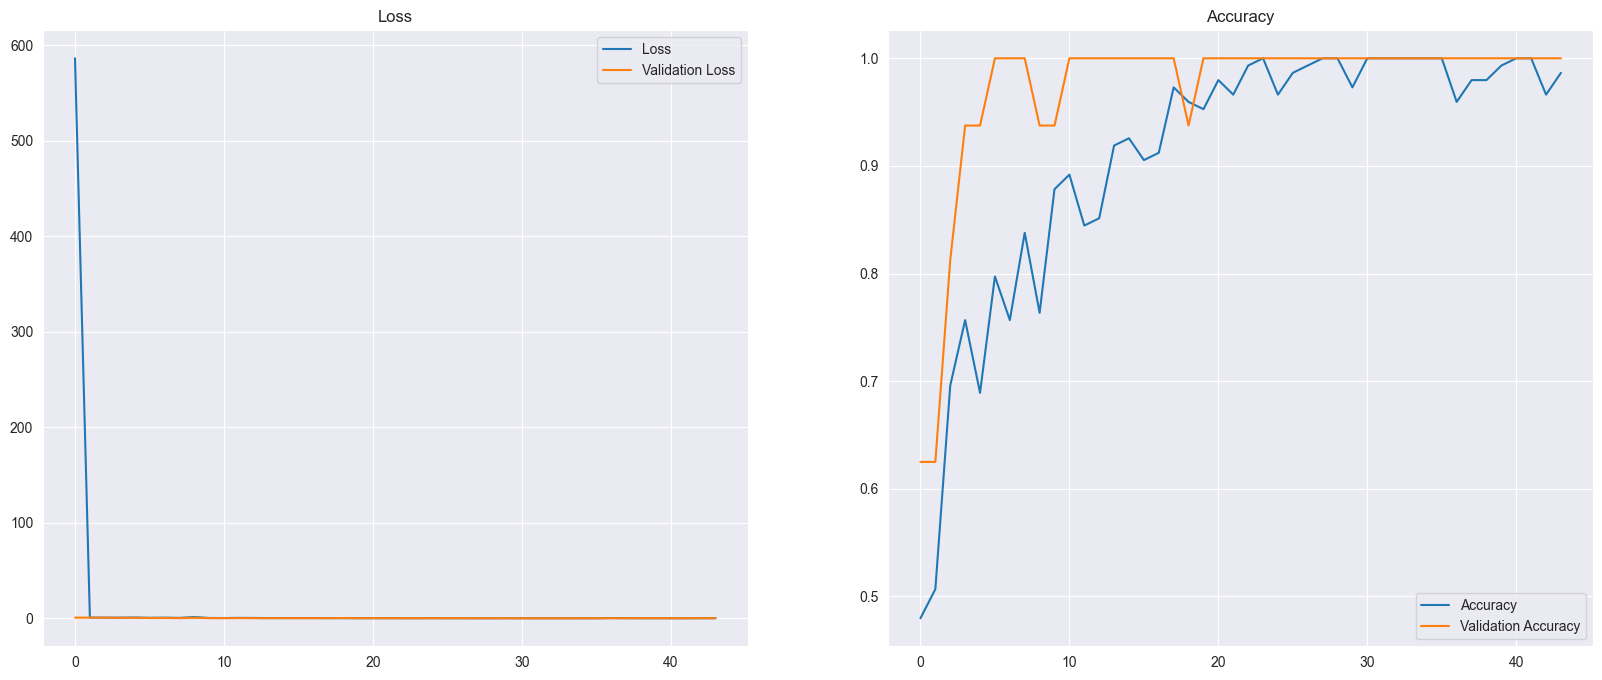

In [23]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set(title = 'Loss')
ax[0].plot(hist3.history['loss'], label = 'Loss')
ax[0].plot(hist3.history['val_loss'], label = 'Validation Loss')
ax[0].legend()

ax[1].set(title = 'Accuracy')
ax[1].plot(hist3.history['accuracy'], label = 'Accuracy')
ax[1].plot(hist3.history['val_accuracy'], label = 'Validation Accuracy')
ax[1].legend()
plt.show()




# Reference

Khoong, W. H. (2020, March 19). Covid-19 XRAY dataset (Train & Test sets). Kaggle. https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets 